***
**Summary**

The enron dataset is initially explored in this notebook.
* Features are first selected based on first human intuition of the dataset. Decision is made based on the explanation of the meaning of each variable, the missing value percentage, etc.
* A bivariate exploratoy investigation is done upon each variable with respect to the response variable to further determine feature selection. In this process, an initial simple missing value filling technique is determined and being used.
* Consider engineer new exploratory variables as features
* Simple models are fitted using one exploratory variable (possibly with different missing value filling strategies) at a time. Further feature selection decision is made based upon the simple models' performances.

***
**Preview**

In the next notebook:
* Further feature selection decision will be made based upon the model performances using pooled features.
* Model Parameter Tunning and Selection: Various models are fitted using the final selected features with different parameter settings, and the best model is selected based upon performances on test set.
* Model performance is evaluated based on performance on cross validation set.
***

In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.linear_model import LinearRegression

from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
%matplotlib inline

## Load Data

In [2]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

## Explore Data, Select Features, Remove Outliers
**Convert data into numpy array and panda DataFrame, Human Intuition Feature Selection**

In [3]:
len(data_dict)

146

In [4]:
my_dataset = data_dict
features_list = ['poi', 'salary', 'bonus', 'expenses','from_messages',\
                 'from_poi_to_this_person', 'to_messages',\
                 'from_this_person_to_poi', 'shared_receipt_with_poi',\
                 'total_payments', 'total_stock_value'
                ]
# Note that the 'NaN' values are replaced with zero in featureFormat func
data = featureFormat(my_dataset, features_list, remove_all_zeroes=False,\
                     sort_keys = True) 
labels, features = targetFeatureSplit(data)

In [5]:
index = sorted(data_dict.keys())

In [6]:
features_data = pd.DataFrame(features, index = index, \
                             columns = features_list[1:])
labels_data = pd.Series(labels, index = index)

In [7]:
features_data.head(2)

,salary,bonus,expenses,from_messages,from_poi_to_this_person,to_messages,from_this_person_to_poi,shared_receipt_with_poi,total_payments,total_stock_value
ALLEN PHILLIP K,201955,4175000,13868,2195,47,2902,65,1407,4484442,1729541
BADUM JAMES P,0,0,3486,0,0,0,0,0,182466,257817


**Investigate missing values**

In [8]:
features_data_bool = features_data==0
# sum up values of each column for each row
row_zeros = features_data_bool.sum(axis=1)

In [9]:
# count how many rows have NaNs/zeroes in all features
print sum(row_zeros==len(features_list)-1)

2


There are 2 samples have missing values in all the 10 features. Find these two samples and exclude them from the data set.

In [10]:
miss_val_index = row_zeros[row_zeros==len(features_list)-1].index

In [11]:
features_data.drop(miss_val_index, inplace=True)
labels_data.drop(miss_val_index, inplace=True)

In [12]:
# investigate the percentage missing vals of each feature
col_zeros = features_data_bool.sum(axis=0)

In [13]:
# percentage of missing values of each feature
print col_zeros/float(len(features_data))

salary                     0.354167
bonus                      0.444444
expenses                   0.354167
from_messages              0.416667
from_poi_to_this_person    0.500000
to_messages                0.416667
from_this_person_to_poi    0.555556
shared_receipt_with_poi    0.416667
total_payments             0.145833
total_stock_value          0.138889
dtype: float64


* high missing values (>40%): from_poi_to_this_person, from_this_person_to_poi, bonus, from_messages, to_messages, shared_receipt_with_poi 
* median missing values (20%~40%): salary, expenses
* low missing values (<20%): total_payments, total_stock_value

** Bivariant Exploratory-Response Variable Feature Selection- Investigate current features' relation with outcome**
* **salary** and **bonus**

In [14]:
def bivar_exp(feature_name):
    '''a func for exploring relationship btw response variable-POI and explainatory variable.
       Given that most the features are numerical, outcome variable is categorical variable, (True vs False),
       a boxplot will be plotted to demonstrate the distribution difference.
    '''
    boxplot_data = [features_data[feature_name][(labels_data==1).values].values,\
                features_data[feature_name][(labels_data==0).values].values]
    plt.boxplot(boxplot_data, labels= ['POI', 'non-POI'])
    return

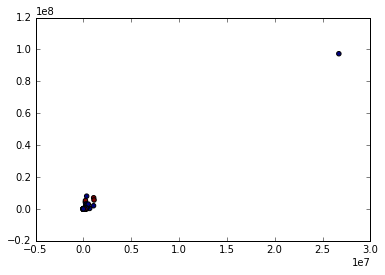

In [15]:
plt.scatter(features_data['salary'], features_data['bonus'], c=labels_data.values)

Identify an abvious outlier. Investigate the outlier.

In [16]:
outlier1_index = features_data.index[features_data['salary']==features_data['salary'].max()]

Remove index 'TOTAL' as an outlier. Replot the scatter plot.

In [17]:
features_data.drop(outlier1_index, inplace=True)
labels_data.drop(outlier1_index, inplace=True)

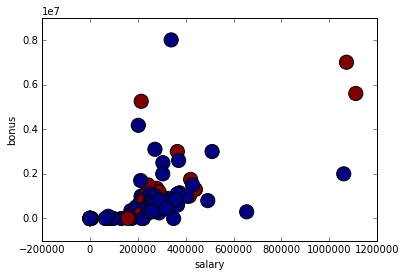

In [18]:
plt.scatter(features_data['salary'], features_data['bonus'], c=labels_data.values, s=200)
plt.xlabel('salary')
plt.ylabel('bonus')

Scatter plot shows that, **salary** and **bonus** have certain level of linear correlation, response variable **poi** does not stand alone in certain area in the scatter plot. Whether **salary** and/or **bonus** will be a good predictor for **poi** requires individual investigation.

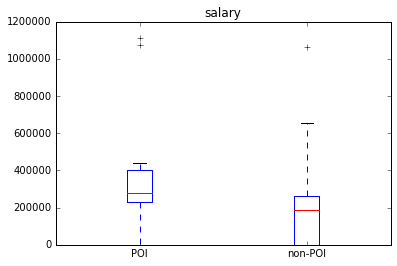

In [19]:
boxplot_salary = [features_data['salary'][(labels_data==1).values].values,\
                features_data['salary'][(labels_data==0).values].values]
plt.boxplot(boxplot_salary, labels= ['POI', 'non-POI'])
plt.title('salary')

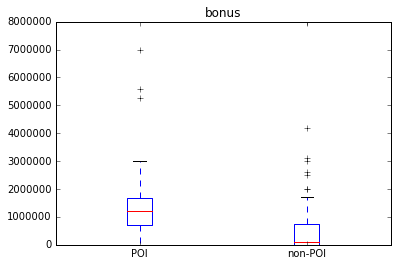

In [20]:
boxplot_bonus = [features_data['bonus'][(labels_data==1).values].values,\
                features_data['bonus'][(labels_data==0).values].values]
plt.boxplot(boxplot_bonus, labels= ['POI', 'non-POI'])
plt.title('bonus')

In [21]:
lg = LinearRegression()
lg.fit(np.reshape(features_data['salary'], (len(features_data),1)), features_data['bonus'])
pred = lg.predict(np.reshape(features_data['salary'], (len(features_data),1)))
residuals = pred - features_data['bonus']

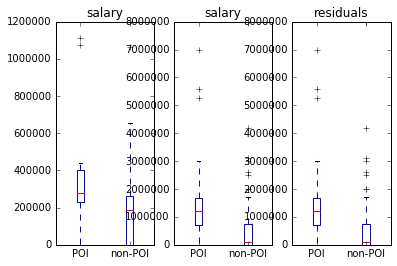

In [22]:
plt.subplot(1,3,1)
boxplot_salary = [features_data['salary'][(labels_data==1).values].values,\
                features_data['salary'][(labels_data==0).values].values]
plt.boxplot(boxplot_salary, labels= ['POI', 'non-POI'])
plt.title('salary')
plt.subplot(1,3,2)
boxplot_salary = [features_data['bonus'][(labels_data==1).values].values,\
                features_data['bonus'][(labels_data==0).values].values]
plt.boxplot(boxplot_salary, labels= ['POI', 'non-POI'])
plt.title('salary')
plt.subplot(1,3,3)
boxplot_rsd = [residuals[(labels_data==1).values].values,\
               residuals[(labels_data==0).values].values]
plt.boxplot(boxplot_bonus, labels= ['POI', 'non-POI'])
plt.title('residuals')

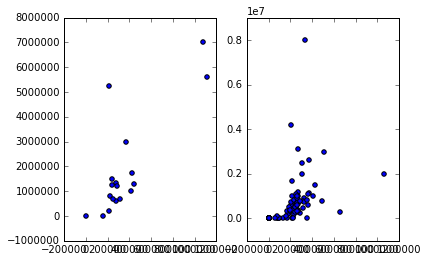

In [23]:
plt.subplot(1,2,1)
plt.scatter(features_data['salary'][(labels_data==1).values].values,\
            features_data['bonus'][(labels_data==1).values].values)
plt.subplot(1,2,2)
plt.scatter(features_data['salary'][(labels_data==0).values].values,\
            features_data['bonus'][(labels_data==0).values].values)

The distributions of salary and bonus are distringuishable: the values of **salary** and **bonus** of **POI** tend to be higher than **non-POI**. But in both **POI** and **non-POI**, the increasing **salary** is correlated with an increasing **bonus**. The residuals distribution is mostly similar to the **bonus** distribution, the seperation of **median** between **POI** and **non-POI** in **bonus** might make **bonus** a better indicator than **salary**.
***
* **expenses**

{'boxes': [<matplotlib.lines.Line2D at 0x113f8d790>,
 'caps': [<matplotlib.lines.Line2D at 0x113f9b6d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x113fa79d0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x113fa7390>,
 'whiskers': [<matplotlib.lines.Line2D at 0x113f8d990>,
  <matplotlib.lines.Line2D at 0x113fb4c90>]}

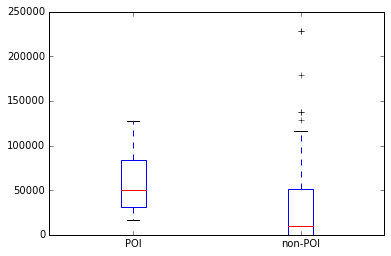

In [24]:
boxplot_exp = [features_data['expenses'][(labels_data==1).values].values,\
                features_data['expenses'][(labels_data==0).values].values]
plt.boxplot(boxplot_exp, labels= ['POI', 'non-POI'])

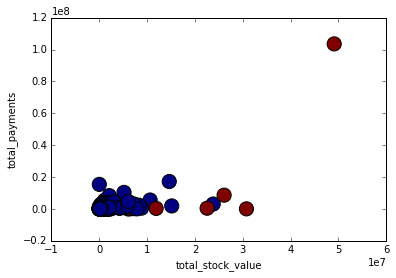

In [278]:
#plt.subplot(1,2,1)
plt.scatter(features_data['total_stock_value'], features_data['total_payments'], c=labels_data.values, s=200)
plt.xlabel('total_stock_value')
plt.ylabel('total_payments')

**expenses** of **POI** seems to be higher than **non-POI** generally, but not a very distinguishable seperation. **salary** demonstrates certain level of linear correlation with respect to expenses, **bonus** has a weaker linear correlation. But the **POI** points and **non-POI** points are all blend in with each other. Drop **expenses** as a features.
***
* **total_payments** and **total_stock_value**

{'boxes': [<matplotlib.lines.Line2D at 0x114566ad0>,
 'caps': [<matplotlib.lines.Line2D at 0x11481e890>,
 'fliers': [<matplotlib.lines.Line2D at 0x114836b90>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x114836550>,
 'whiskers': [<matplotlib.lines.Line2D at 0x114566610>,
  <matplotlib.lines.Line2D at 0x114843e50>]}

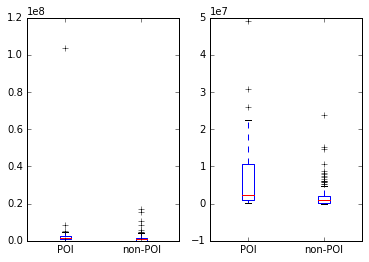

In [26]:
plt.subplot(1,2,1)
boxplot_totpay = [features_data['total_payments'][(labels_data==1).values].values,\
                features_data['total_payments'][(labels_data==0).values].values]
plt.boxplot(boxplot_totpay, labels= ['POI', 'non-POI'])
plt.subplot(1,2,2)
boxplot_totstc = [features_data['total_stock_value'][(labels_data==1).values].values,\
                features_data['total_stock_value'][(labels_data==0).values].values]
plt.boxplot(boxplot_totstc, labels= ['POI', 'non-POI'])

In [27]:
# Remove the outlier in **total_payments** to see the districution characteristics
features_temp = features_data.drop(\
                features_data.index[features_data['total_payments']==features_data['total_payments'].max()])
labels_temp = labels_data.drop(\
              features_data.index[features_data['total_payments']==features_data['total_payments'].max()])

{'boxes': [<matplotlib.lines.Line2D at 0x1149d51d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1149e1110>,
 'fliers': [<matplotlib.lines.Line2D at 0x1149ec410>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1149e1d90>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1149d53d0>,
  <matplotlib.lines.Line2D at 0x1149fa6d0>]}

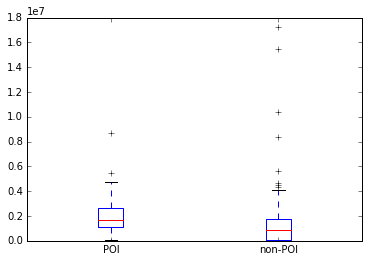

In [28]:
boxplot_temp = [features_temp['total_payments'][(labels_temp==1).values].values,\
                features_temp['total_payments'][(labels_temp==0).values].values]
plt.boxplot(boxplot_temp, labels= ['POI', 'non-POI'])

In [ ]:
plt.subplot(1,2,1)
plt.scatter(features_data['salary'], features_data['bonus'], c=labels_data.values, s=200)
plt.xlabel('salary')
plt.ylabel('expenses')
plt.subplot(1,2,2)
plt.scatter(features_data['bonus'], features_data['expenses'], c=labels_data.values, s=200)
plt.xlabel('bonus')
plt.ylabel('expenses')

**total_stock_value** could potentially be a good predictor for **POI**, drop **total_payments** as a feature.
***
* **from_messages** and **from_this_person_to_poi**

In [29]:
index = features_data.index[features_data['from_this_person_to_poi']>200]
temp_features = features_data.drop(index)
temp_labels = labels_data.drop(index)

{'boxes': [<matplotlib.lines.Line2D at 0x114b5d450>,
 'caps': [<matplotlib.lines.Line2D at 0x114b6b390>,
 'fliers': [<matplotlib.lines.Line2D at 0x114b78690>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x114b78050>,
 'whiskers': [<matplotlib.lines.Line2D at 0x114b5d650>,
  <matplotlib.lines.Line2D at 0x114b83950>]}

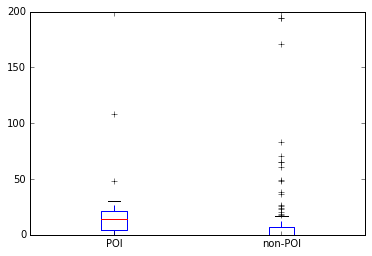

In [30]:
boxplot_to_poi = [temp_features['from_this_person_to_poi'][(temp_labels==1).values].values,\
                  temp_features['from_this_person_to_poi'][(temp_labels==0).values].values]
plt.boxplot(boxplot_to_poi, labels= ['POI', 'non-POI'])

**from_this_person_to_poi** is not a good predictor. It also might makes sense since a lot of the **POI** are important person in the company, therefore a lot of people might send emails to them due to work necessity. Drop **from_this_person_to_poi** as a predictor.

In [31]:
def comp_ratio_from(row):
    if row['from_messages']==0:
        return None
    else:
        return float(row['from_this_person_to_poi'])/row['from_messages']
from_ratio = features_data.apply(comp_ratio_from,axis=1)

{'boxes': [<matplotlib.lines.Line2D at 0x114deea50>,
 'caps': [<matplotlib.lines.Line2D at 0x114dfd990>,
 'fliers': [<matplotlib.lines.Line2D at 0x114e09c90>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x114e09650>,
 'whiskers': [<matplotlib.lines.Line2D at 0x114deec50>,
  <matplotlib.lines.Line2D at 0x114e14f50>]}

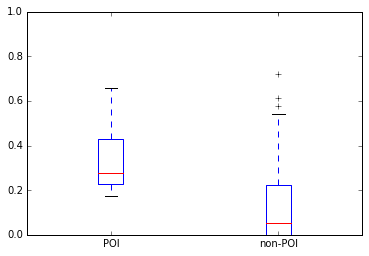

In [32]:
boxplot_from_ratio = [from_ratio[(labels_data==1).values].dropna().values,\
                      from_ratio[(labels_data==0).values].dropna().values]
plt.boxplot(boxplot_from_ratio, labels= ['POI', 'non-POI'])

In [33]:
print "mean of POI's from_person_to_poi/from_messages ratio: ", boxplot_from_ratio[0].mean()
print "mean of non-POI's from_person_to_poi/from_messages ratio: ", boxplot_from_ratio[1].mean()

mean of POI's from_person_to_poi/from_messages ratio:  0.345469813626
mean of non-POI's from_person_to_poi/from_messages ratio:  0.152669361977


In [34]:
print "overall mean: ", (boxplot_from_ratio[0].mean()*len(boxplot_from_ratio[0])+ \
                         boxplot_from_ratio[1].mean()*len(boxplot_from_ratio[1]))/ \
                        (len(boxplot_from_ratio[0]) + len(boxplot_from_ratio[1]))

overall mean:  0.184055482013


The ratio of **from_this_person_to_poi**/**from_messages** is potentially a good indicator for predicting **POI**.

Investigate the points with missing **from_messages**.

In [35]:
miss_from_index = set(from_ratio.index[from_ratio.isnull()])
print len(miss_from_index)

57


In [36]:
pois = set(labels_data.index[labels_data==1])

In [37]:
print (miss_from_index & pois)

set(['HIRKO JOSEPH', 'FASTOW ANDREW S', 'KOPPER MICHAEL J', 'YEAGER F SCOTT'])


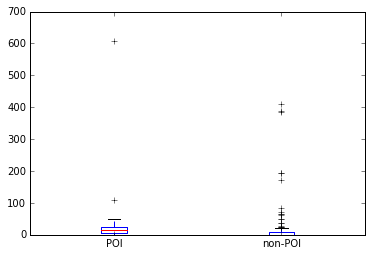

In [38]:
bivar_exp('from_this_person_to_poi') #bivar_exp("from_messages")

Among the 57 samples with missing values in **from_messages**, there are 4 samples are POI. Since filling in values with 0 will cause the result biased towards **non-POI**, whereas filling in a value too high will biase towards **POI**. Therefore plan to fill in the missing value with the overall mean of available values: **0.1841**. Since it's above the average of **non-POI**, but lower than the average of **POI**. Drop **from_this_person_to_poi** and **from_messages** as features.
***
* **to_messages** and **from_poi_to_this_person**

In [39]:
def comp_ratio_to(row):
    if row['to_messages']==0:
        return None
    else:
        return float(row['from_poi_to_this_person'])/row['to_messages']
to_ratio = features_data.apply(comp_ratio_to,axis=1)

{'boxes': [<matplotlib.lines.Line2D at 0x1150e0a10>,
 'caps': [<matplotlib.lines.Line2D at 0x1150ee950>,
 'fliers': [<matplotlib.lines.Line2D at 0x1150fbc50>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1150fb610>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1150e0c10>,
  <matplotlib.lines.Line2D at 0x115107f10>]}

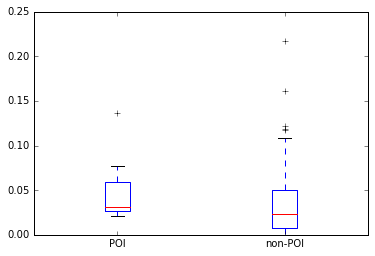

In [40]:
boxplot_to_ratio = [to_ratio[(labels_data==1).values].dropna().values,\
                      to_ratio[(labels_data==0).values].dropna().values]
plt.boxplot(boxplot_to_ratio, labels= ['POI', 'non-POI'])

In [41]:
print "mean of POI's from_poi_to_this_person/to_messages ratio: ", boxplot_to_ratio[0].mean()
print "mean of non-POI's from_poi_to_this_person/to_messages ratio: ", boxplot_to_ratio[1].mean()

mean of POI's from_poi_to_this_person/to_messages ratio:  0.0475067013416
mean of non-POI's from_poi_to_this_person/to_messages ratio:  0.0361072546128


In [42]:
print "overall mean: ", (boxplot_to_ratio[0].mean()*len(boxplot_to_ratio[0])+ \
                         boxplot_to_ratio[1].mean()*len(boxplot_to_ratio[1]))/ \
                        (len(boxplot_to_ratio[0]) + len(boxplot_to_ratio[1]))

overall mean:  0.0379629784989


In [43]:
miss_to_index = set(from_ratio.index[from_ratio.isnull()])
print len(miss_to_index)

57


In [44]:
print (miss_to_index & pois)

set(['HIRKO JOSEPH', 'FASTOW ANDREW S', 'KOPPER MICHAEL J', 'YEAGER F SCOTT'])


The **from_poi_to_this_person**/**to_message** ratio does not distinguish **POI** and **non-POI** groups ver well. Although the samples with missing values in **to_message** and **from_messages** are probably the same samples.

{'boxes': [<matplotlib.lines.Line2D at 0x114fae390>,
 'caps': [<matplotlib.lines.Line2D at 0x114bd5bd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x114e60150>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x114bc5350>,
 'whiskers': [<matplotlib.lines.Line2D at 0x114a59dd0>,
  <matplotlib.lines.Line2D at 0x114d0e710>]}

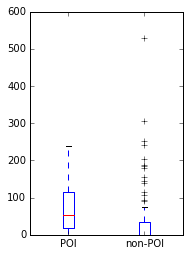

In [45]:
plt.subplot(1,2,1)
boxplot_from_poi = [features_data['from_poi_to_this_person'][(labels_data==1).values].values,\
                features_data['from_poi_to_this_person'][(labels_data==0).values].values]
plt.boxplot(boxplot_from_poi, labels= ['POI', 'non-POI'])

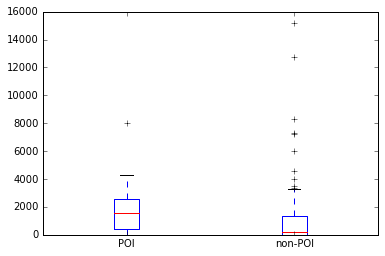

In [46]:
bivar_exp("to_messages")

Drop **to_messages** as a feature, keep **from_poi_to_this_person** as a feature.
***
* **shared_receipt_with_poi**

{'boxes': [<matplotlib.lines.Line2D at 0x11548c1d0>,
 'caps': [<matplotlib.lines.Line2D at 0x115497110>,
 'fliers': [<matplotlib.lines.Line2D at 0x1154a3410>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x115497d90>,
 'whiskers': [<matplotlib.lines.Line2D at 0x11548c3d0>,
  <matplotlib.lines.Line2D at 0x1154b16d0>]}

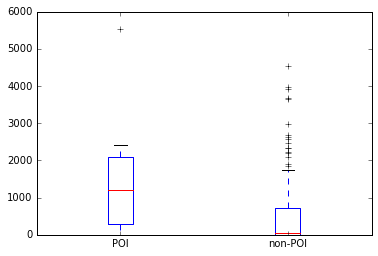

In [47]:
boxplot_shared = [features_data['shared_receipt_with_poi'][(labels_data==1).values].values,\
                features_data['shared_receipt_with_poi'][(labels_data==0).values].values]
plt.boxplot(boxplot_shared, labels= ['POI', 'non-POI'])

***
* Investigate correlation btw **total_payments** and **total_stock_value** with respect to **salary**, **bonus**. Strategies for filling in missing values in **salary** and **bonus**

***
**Summary**

* selecting features: **salary**, **bonus**, **total_stock_value**, **shared_recepit_with_poi**, **from_this_person_to_poi**
* engineering features: **from_this_person_to_poi/from_messages**
* strategy for dealing with missing values: **filling 0 for NaN**

In [48]:
select_features = ['salary', 'bonus', 'total_stock_value', 'shared_receipt_with_poi', 'from_poi_to_this_person',
                   'from_messages', "from_this_person_to_poi"
                  ]
features_data_sel = features_data[select_features]
features_data_sel.head(2)

,salary,bonus,total_stock_value,shared_receipt_with_poi,from_poi_to_this_person,from_messages,from_this_person_to_poi
ALLEN PHILLIP K,201955,4175000,1729541,1407,47,2195,65
BADUM JAMES P,0,0,257817,0,0,0,0


In [49]:
def fill_from_ratio(row):
    if row['from_messages']==0:
        return 0.1841
    else:
        return float(row['from_this_person_to_poi'])/row['from_messages']
from_ratio = features_data.apply(comp_ratio_from,axis=1)

In [50]:
features_data_sel['from_ratio'] = features_data_sel.apply(fill_from_ratio, axis=1)
features_data_sel.drop(['from_messages','from_this_person_to_poi'], axis=1, inplace=True)
features_data_sel.rename(columns={'from_poi_to_this_person':'poi_to_this_person'}, inplace=True)
features_data_sel.head(2)

/Users/Zhongyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Zhongyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Zhongyu/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

,salary,bonus,total_stock_value,shared_receipt_with_poi,poi_to_this_person,from_ratio
ALLEN PHILLIP K,201955,4175000,1729541,1407,47,0.029613
BADUM JAMES P,0,0,257817,0,0,0.184100


## Split Data, Train Simple Models, Select Features Based on Performance on Simple Models
***
### Split Data into training and testing set

In [51]:
features_train, features_test, labels_train, labels_test = train_test_split(features_data_sel, labels_data,
                                                                            test_size=0.3, random_state=89)

***
### Train and Evaluate Classifiers (all features): GaussianNB, KNN, Adaptive Boost, Random Forest, Decision Tree
Note SVC takes too long to train and terminate, therefore discard SVC as classifier options here
* **Train classifier based on all features**

In [52]:
def classifier(clf_obj):
    clf_obj.fit(features_train, labels_train)
    pred_clf = clf_obj.predict(features_test)
    print "F1 score on training set: ", f1_score(labels_train, clf_obj.predict(features_train))
    print "F1 score on testing set: ", f1_score(labels_test, pred_clf)
    print confusion_matrix(labels_test, pred_clf)
    return clf_obj

In [53]:
# GaussianNB
clf_gnb = GaussianNB()
clf_gnb.fit(features_train, labels_train)
pred_gnb = clf_gnb.predict(features_test)
print "F1 score on training set: ", f1_score(labels_train, clf_gnb.predict(features_train))
print "F1 score on testing set: ", f1_score(labels_test, pred_gnb)
print confusion_matrix(labels_test, pred_gnb)

F1 score on training set:  0.190476190476
F1 score on testing set:  0.5
[[37  0]
 [ 4  2]]


In [54]:
# KNN
clf_knn = KNeighborsClassifier(n_neighbors=5,weights='distance')
clf_knn = classifier(clf_knn)

F1 score on training set:  1.0
F1 score on testing set:  0.25
[[36  1]
 [ 5  1]]


In [131]:
# Decision Tree - Not very stable when random_state set to None
clf_dt = DecisionTreeClassifier(criterion='entropy', splitter='best', min_samples_split=5,
                                min_samples_leaf=2 ,random_state=None)
clf_dt = classifier(clf_dt)

F1 score on training set:  0.923076923077
F1 score on testing set:  0.545454545455
[[35  2]
 [ 3  3]]


In [132]:
# Adaptive Boost - pretty stable not matter how clf_dt's performance is
clf_adb = AdaBoostClassifier(base_estimator=clf_dt, learning_rate=0.01, random_state=None)
clf_adb = classifier(clf_adb)

F1 score on training set:  1.0
F1 score on testing set:  0.833333333333
[[36  1]
 [ 1  5]]


In [133]:
# Random Forest - not stable when random_state set to None
clf_rdf = RandomForestClassifier(n_estimators=5, criterion='entropy', min_samples_split=5,
                                 min_samples_leaf=2, random_state = None)
clf_rdf = classifier(clf_rdf)

F1 score on training set:  0.782608695652
F1 score on testing set:  0.545454545455
[[35  2]
 [ 3  3]]


* **Investigate classifier performance with one feature at a time**

In [134]:
def classifier_select_feature(clf_obj, select_feature):
    clf_obj.fit(features_train[select_feature], labels_train)
    pred_clf = clf_obj.predict(features_test[select_feature])
    print "F1 score on training set: ", f1_score(labels_train, clf_obj.predict(features_train[select_feature]))
    print "F1 score on testing set: ", f1_score(labels_test, pred_clf)
    print confusion_matrix(labels_test, pred_clf)
    return clf_obj

In [235]:
def examine_feature(all_features):
    for f in all_features:
        print "===============", f,"========================="
        print "------- GaussianNB Classifier -----------"
        clf_gnb1 = GaussianNB()
        clf_gnb1 = classifier_select_feature(clf_gnb1, [f])
        print "------- DecisionTree Classifier -----------"
        clf_dt1 = DecisionTreeClassifier(criterion='entropy', splitter='best', min_samples_split=5,
                                min_samples_leaf=2 ,random_state=None)
        clf_dt1 = classifier_select_feature(clf_dt1, [f])
        print "------- AdaBoost Classifier -----------"
        clf_adb1 = AdaBoostClassifier(base_estimator=clf_dt1, learning_rate=0.01, random_state=None)
        clf_adb1 = classifier_select_feature(clf_adb1, [f])

* Missing values are filled with 0

In [273]:
all_features = ['salary','bonus','total_stock_value','shared_receipt_with_poi','poi_to_this_person','from_ratio']
examine_feature(all_features)

=============== salary =========================
------- GaussianNB Classifier -----------
F1 score on training set:  0.0
F1 score on testing set:  0.0
[[37  0]
 [ 6  0]]
------- DecisionTree Classifier -----------
F1 score on training set:  0.470588235294
F1 score on testing set:  0.0
[[37  0]
 [ 6  0]]
------- AdaBoost Classifier -----------
F1 score on training set:  0.782608695652
F1 score on testing set:  0.0
[[35  2]
 [ 6  0]]
=============== bonus =========================
------- GaussianNB Classifier -----------
F1 score on training set:  0.133333333333
F1 score on testing set:  0.5
[[37  0]
 [ 4  2]]
------- DecisionTree Classifier -----------
F1 score on training set:  0.285714285714
F1 score on testing set:  0.285714285714
[[37  0]
 [ 5  1]]
------- AdaBoost Classifier -----------
F1 score on training set:  0.285714285714
F1 score on testing set:  0.285714285714
[[37  0]
 [ 5  1]]
=============== total_stock_value =========================
------- GaussianNB Classifier ----

* Fill missing value with average

In [268]:
def fill_with_mean():
    fill_cols = features_train.columns[:-1]
    for col in fill_cols:
        non_miss_index = features_train.index[features_train[col]!=0]
        avg = np.mean(features_train[col][non_miss_index])
        features_train[col].replace(0, avg, inplace=True)
        features_test[col].replace(0, avg, inplace=True)
    return

In [269]:
fill_with_mean()

/Users/Zhongyu/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2859: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [270]:
features_train.head(3)

,salary,bonus,total_stock_value,shared_receipt_with_poi,poi_to_this_person,from_ratio
KISHKILL JOSEPH G,174246.000000,1163926.232143,1034346.000000,1234.112903,79.290909,0.184100
FUGH JOHN L,263149.477612,1163926.232143,176378.000000,1234.112903,79.290909,0.184100
CARTER REBECCA C,261809.000000,300000.000000,3004434.908046,196.000000,29.000000,0.466667


In [272]:
all_features = ['salary','bonus','total_stock_value','shared_receipt_with_poi','poi_to_this_person','from_ratio']
examine_feature(all_features)

=============== salary =========================
------- GaussianNB Classifier -----------
F1 score on training set:  0.0
F1 score on testing set:  0.0
[[37  0]
 [ 6  0]]
------- DecisionTree Classifier -----------
F1 score on training set:  0.470588235294
F1 score on testing set:  0.0
[[37  0]
 [ 6  0]]
------- AdaBoost Classifier -----------
F1 score on training set:  0.782608695652
F1 score on testing set:  0.0
[[35  2]
 [ 6  0]]
=============== bonus =========================
------- GaussianNB Classifier -----------
F1 score on training set:  0.133333333333
F1 score on testing set:  0.5
[[37  0]
 [ 4  2]]
------- DecisionTree Classifier -----------
F1 score on training set:  0.285714285714
F1 score on testing set:  0.285714285714
[[37  0]
 [ 5  1]]
------- AdaBoost Classifier -----------
F1 score on training set:  0.285714285714
F1 score on testing set:  0.285714285714
[[37  0]
 [ 5  1]]
=============== total_stock_value =========================
------- GaussianNB Classifier ----

**Summary**
Drop **salary** and **poi_to_this_person** as features. 

Some final experiments to explore the performance of selected variables

In [281]:
sel_features = ['bonus','total_stock_value','shared_receipt_with_poi','poi_to_this_person']

In [308]:
clf_adb = AdaBoostClassifier(base_estimator=clf_dt, learning_rate=0.1, random_state=None)
clf_adb = classifier_select_feature(clf_adb, sel_features )

F1 score on training set:  1.0
F1 score on testing set:  0.5
[[34  3]
 [ 3  3]]


In [323]:
clf_rdf = RandomForestClassifier(n_estimators=5, criterion='entropy', min_samples_split=5,
                                 min_samples_leaf=2, random_state = 94)
clf_rdf = classifier_select_feature(clf_rdf, sel_features)

F1 score on training set:  0.526315789474
F1 score on testing set:  0.444444444444
[[36  1]
 [ 4  2]]


In [326]:
clf_gnb = GaussianNB()
clf_gnb = classifier_select_feature(clf_gnb, sel_features)

F1 score on training set:  0.190476190476
F1 score on testing set:  0.666666666667
[[37  0]
 [ 3  3]]
